In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
cd /Users/fred/Umila/numila

/Users/fred/Umila/numila


In [4]:
from sklearn import metrics
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('muted')

from main import run


# ROC

In [37]:
roc_df = pd.read_pickle('pickles/lretir_roc')
# roc_df['holo'] = [name.startswith('holo') for name in roc_df.model]
roc_df.head()

,auc,fpr,model,tpr,lang,kind
0,0.738462,"[0.0, 0.0, 0.153846153846, 0.307692307692, 1.0]",0.05_0.15_0,"[0.2, 0.6, 0.6, 0.6, 1.0]",English,word
1,0.807692,"[0.0, 0.0, 0.307692307692, 0.307692307692, 1.0]",0.05_0.15_1,"[0.2, 0.6, 0.6, 0.8, 1.0]",English,word
2,0.930769,"[0.0, 0.0, 0.153846153846, 0.153846153846, 0.2...",0.05_0.15_4,"[0.2, 0.6, 0.6, 0.8, 1.0, 1.0]",English,word
3,0.769231,"[0.0, 0.0, 0.153846153846, 1.0]",0.05_0.2_0,"[0.2, 0.6, 0.6, 1.0]",English,word
4,0.692308,"[0.0, 0.0, 0.538461538462, 1.0]",0.05_0.2_1,"[0.2, 0.6, 0.6, 1.0]",English,word


In [35]:
def parse_name(name):
    return tuple(map(float, name.split('_')))
    

roc_df['learn_rate'], roc_df['exemplar'], roc_df['init_row'] = \
   zip(*[parse_name(name) for name in roc_df.model])

In [42]:
roc_df.groupby('model').auc.mean().sort_values()

model
0.1_0.2_4      0.695609
0.1_0.15_4     0.715992
0.05_0.2_1     0.717359
0.1_0.15_0     0.720808
0.1_0.15_1     0.724256
0.2_0.2_4      0.729915
0.2_0.3_1      0.733516
0.2_0.3_0      0.735043
0.1_0.3_0      0.735355
0.2_0.15_1     0.739240
0.1_0.2_0      0.740701
0.05_0.15_0    0.741786
0.05_0.2_4     0.742334
0.2_0.2_1      0.743130
0.2_0.2_0      0.745146
0.05_0.2_0     0.747291
0.1_0.3_1      0.748789
0.05_0.3_0     0.750740
0.2_0.15_4     0.753581
0.1_0.2_1      0.757477
0.2_0.15_0     0.766077
0.05_0.15_1    0.767162
0.05_0.3_4     0.770292
0.05_0.3_1     0.786325
0.2_0.3_4      0.787009
0.05_0.15_4    0.789797
0.1_0.3_4      0.820094
Name: auc, dtype: float64

In [36]:


for kind in 'word', 'syl', 'phone':
    top = roc_df[roc_df.kind == kind].sort_values('auc', ascending=False)[:3]
    print('\n', '--', kind)
    for i, row in top.iterrows():
        print(row.auc, row.learn_rate, row.exemplar, row.init_row)



 -- word
0.9307692307692307 0.05 0.15 4.0
0.8923076923076922 0.05 0.3 1.0
0.8538461538461538 0.1 0.3 4.0

 -- syl
0.8133333333333332 0.1 0.3 4.0
0.7533333333333334 0.2 0.3 4.0
0.7533333333333334 0.2 0.3 1.0

 -- phone
0.8344827586206897 0.1 0.2 1.0
0.8137931034482759 0.1 0.15 1.0
0.8137931034482758 0.05 0.15 1.0


In [6]:
def roc_plot(df):
    ax = plt.subplot(1,1,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    for i, row in df.iterrows():
        plt.plot(row.fpr, row.tpr, label='{0} (area = {1:0.2f})'
                 .format(row.model, row['auc']))

    # Sort labels in legend.
    handles, labels = ax.get_legend_handles_labels()
    def get_aoc(handle_label):
        label = handle_label[1]
        return float(label[-5:-1])
    hl = sorted(zip(handles, labels), key=get_aoc, reverse=True)
    handles2, labels2 = zip(*hl)
    ax.legend(handles2, labels2, loc=4, frameon=True)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.gcf().set_size_inches(6, 6)

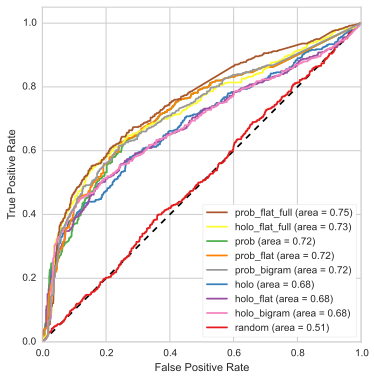

In [7]:
# Plot roc curve for English words.
with sns.color_palette('Set1', 10):
    roc_plot(roc_df.query("lang == 'English' and kind == 'word'"))
    # roc_plot(roc_df)
    plt.savefig('figs/roc-curve.pdf')

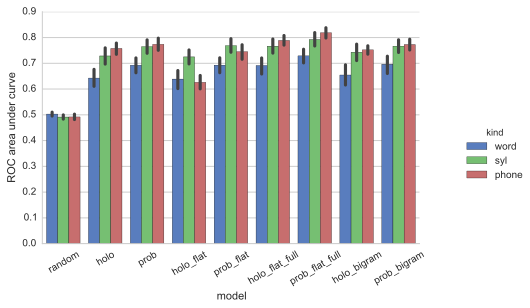

In [16]:
# ROC auc for each model and input type, collapsed across language
sns.factorplot('model', 'auc', hue='kind', kind='bar', data=roc_df)

plt.xticks(rotation=30)
plt.ylabel('ROC area under curve')
plt.gcf().set_size_inches(8, 4)
plt.savefig('figs/roc-type.pdf')

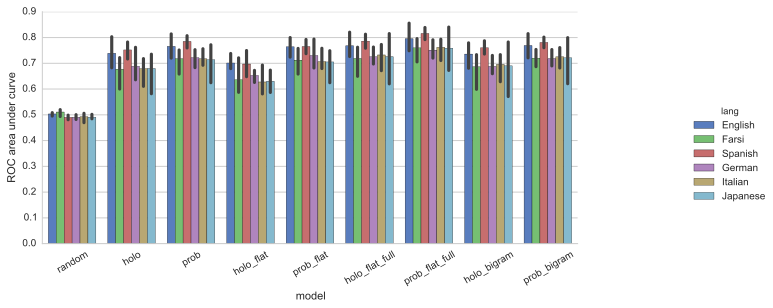

In [15]:
# ROC auc for each model and language, collapsed across input type.
sns.factorplot('model', 'auc', hue='lang', kind='bar', data=roc_df)

plt.xticks(rotation=30)
plt.ylabel('ROC area under curve')
plt.gcf().set_size_inches(12, 4)
plt.savefig('figs/roc-lang.pdf')

# BLEU

In [11]:
bleu_df = pd.read_pickle('pickles/bleu')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

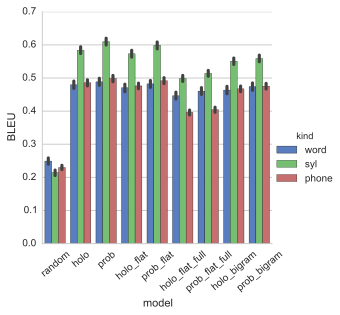

In [12]:
sns.factorplot(x='model', y='BLEU', hue='kind', data=bleu_df, kind='bar',
#             order=['holo', 'compose', 'prob',  'trigram']
               )
# plt.legend().draw_frame(True)
plt.savefig('figs/bleu.pdf')
plt.xticks(rotation=40)

In [13]:
# full_df = roc_df[['ROC area under curve', 'model', 'language']].rename(columns={'ROC area under curve': 'measure'}).head()

full_df = pd.concat([pd.melt(roc_df, id_vars=['model', 'language'],
                   value_vars=['ROC area under curve'], var_name='measure'), 
           pd.melt(bleu_df, id_vars=['model', 'language'],
                   value_vars=['BLEU'], var_name='measure')])
    
sns.factorplot('model', 'value', hue='language', col='measure', data=full_df,
                   kind='bar', col_order=['BLEU', 'ROC area under curve'],
                   order=['holo', 'prob', 'trigram', 'random'])
plt.savefig('figs/combined.pdf')

ValueError: min() arg is an empty sequence